In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES

In [23]:
#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

#Description
print(market_price.head())
print("\nShape is:", market_price.shape)
print("\nSummary of the dataset:")
market_price.describe()
print("\nAre there null values?")
market_price.isna().sum()

   Timestamp  Price
0 2009-01-02    0.0
1 2009-01-05    0.0
2 2009-01-08    0.0
3 2009-01-11    0.0
4 2009-01-14    0.0

Shape is: (1665, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Price        0
dtype: int64

In [24]:
#NEW ADDRESSES
new_addresses = pd.read_csv("data/bitcoin-number-of-new-addresses.csv")

new_addresses["New Addresses/t"] = new_addresses["New Addresses/t"].str.rstrip("T00:00:00.000Z")
new_addresses["New Addresses/t"] = pd.to_datetime(new_addresses["New Addresses/t"])
new_addresses = new_addresses.sort_values(by='New Addresses/t')
new_addresses = new_addresses.rename(columns={'New Addresses/t': 'Timestamp', 'New Addresses/v': 'Value'})

#Description
print(new_addresses.head())
print("\nShape is:", new_addresses.shape)
print("\nSummary of the dataset:")
new_addresses.describe()
print("\nAre there null values?")
new_addresses.isna().sum()

    Timestamp  Value
7  2009-01-01     61
17 2009-01-02    115
0  2009-01-03      1
27 2009-01-03    117
1  2009-01-04      0

Shape is: (4988, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [25]:
#ACTIVE ADDRESSES
active_addresses = pd.read_csv("data/bitcoin-number-of-active-addresses.csv")

active_addresses["Active Addresses/t"] = active_addresses["Active Addresses/t"].str.rstrip("T00:00:00.000Z")
active_addresses["Active Addresses/t"] = pd.to_datetime(active_addresses["Active Addresses/t"])
active_addresses = active_addresses.sort_values(by='Active Addresses/t')
active_addresses = active_addresses.rename(columns={'Active Addresses/t': 'Timestamp', 'Active Addresses/v': 'Value'})

#Description
print(active_addresses.head())
print("\nShape is:", active_addresses.shape)
print("\nSummary of the dataset:")
active_addresses.describe()
print("\nAre there null values?")
active_addresses.isna().sum()

   Timestamp  Value
0 2008-12-29      0
1 2009-01-05      0
2 2009-01-12     34
3 2009-01-19     63
4 2009-01-26     61

Shape is: (713, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [26]:
#BLOCK HEIGHT
block_height = pd.read_csv("data/bitcoin-block-height.csv")

block_height["Block Height/t"] = block_height["Block Height/t"].str.rstrip("T00:00:00.000Z")
block_height["Block Height/t"] = pd.to_datetime(block_height["Block Height/t"])
block_height = block_height.sort_values(by='Block Height/t')
block_height = block_height.rename(columns={'Block Height/t': 'Timestamp', 'Block Height/v': 'Value'})

#Description
print(block_height.head())
print("\nShape is:", block_height.shape)
print("\nSummary of the dataset:")
block_height.describe()
print("\nAre there null values?")
block_height.isna().sum()

    Timestamp  Value
1  2009-01-01     75
11 2009-01-02   1193
21 2009-01-03   2405
0  2009-01-09     14
2  2009-01-11    168

Shape is: (4982, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [36]:
#DIFFICULTY RIBBON
difficulty_ribbon = pd.read_csv("data/bitcoin-difficulty-ribbon.csv")

difficulty_ribbon["Difficulty Ribbon/t"] = difficulty_ribbon["Difficulty Ribbon/t"].str.rstrip("T00:00:00.000Z")
difficulty_ribbon["Difficulty Ribbon/t"] = pd.to_datetime(difficulty_ribbon["Difficulty Ribbon/t"])
difficulty_ribbon = difficulty_ribbon.sort_values(by='Difficulty Ribbon/t')
difficulty_ribbon = difficulty_ribbon.rename(columns={'Difficulty Ribbon/t': 'Timestamp'})
difficulty_ribbon.head()

Timestamp  Difficulty Ribbon/o/ma128  Difficulty Ribbon/o/ma14  \
2 2009-07-03               4.294967e+09              4.294967e+09   
0 2009-07-28               4.294967e+09              4.294967e+09   
1 2009-07-29               4.294967e+09              4.294967e+09   
3 2009-07-31               4.294967e+09              4.294967e+09   
4 2009-08-01               4.294967e+09              4.294967e+09   

   Difficulty Ribbon/o/ma200  Difficulty Ribbon/o/ma25  \
2               4.294967e+09              4.294967e+09   
0               4.294967e+09              4.294967e+09   
1               4.294967e+09              4.294967e+09   
3               4.294967e+09              4.294967e+09   
4               4.294967e+09              4.294967e+09   

   Difficulty Ribbon/o/ma40  Difficulty Ribbon/o/ma60  \
2              4.294967e+09              4.294967e+09   
0              4.294967e+09              4.294967e+09   
1              4.294967e+09              4.294967e+09   
3              4.294967e+09              4.294967e+09   
4              4.294967e+09              4.294967e+09   

   Difficulty Ribbon/o/ma9  Difficulty Ribbon/o/ma90  
2             4.294967e+09              4.294967e+09  
0             4.294967e+09              4.294967e+09  
1             4.294967e+09              4.294967e+09  
3             4.294967e+09              4.294967e+09  
4             4.294967e+09              4.294967e+09

In [37]:
#Description
print("\nShape is:", difficulty_ribbon.shape)
print("\nSummary of the dataset:")
difficulty_ribbon.describe()
print("\nAre there null values?")
difficulty_ribbon.isna().sum()


Shape is: (4782, 9)

Summary of the dataset:

Are there null values?


Timestamp                    0
Difficulty Ribbon/o/ma128    0
Difficulty Ribbon/o/ma14     0
Difficulty Ribbon/o/ma200    0
Difficulty Ribbon/o/ma25     0
Difficulty Ribbon/o/ma40     0
Difficulty Ribbon/o/ma60     0
Difficulty Ribbon/o/ma9      0
Difficulty Ribbon/o/ma90     0
dtype: int64

In [38]:
#MARKET CAP
market_cap_usd = pd.read_csv("data/bitcoin-market-cap-usd.csv")

market_cap_usd["Market Cap/t"] = market_cap_usd["Market Cap/t"].str.rstrip("T00:00:00.000Z")
market_cap_usd["Market Cap/t"] = pd.to_datetime(market_cap_usd["Market Cap/t"])
market_cap_usd = market_cap_usd.sort_values(by='Market Cap/t')
market_cap_usd = market_cap_usd.rename(columns={'Market Cap/t': 'Timestamp', 'Market Cap/v': 'Value'})

#Description
print(market_cap_usd.head())
print("\nShape is:", market_cap_usd.shape)
print("\nSummary of the dataset:")
market_cap_usd.describe()
print("\nAre there null values?")
market_cap_usd.isna().sum()

    Timestamp          Value
3  2010-07-02  258977.156667
13 2010-07-03  228957.948333
0  2010-07-17  170264.890000
1  2010-07-18  295941.984000
2  2010-07-19  279269.040000

Shape is: (4428, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [39]:
#HASH RATE
hash_rate = pd.read_csv("data/bitcoin-mean-hash-rate.csv")

hash_rate["Hash Rate/t"] = hash_rate["Hash Rate/t"].str.rstrip("T00:00:00.000Z")
hash_rate["Hash Rate/t"] = pd.to_datetime(hash_rate["Hash Rate/t"])
hash_rate = hash_rate.sort_values(by='Hash Rate/t')
hash_rate = hash_rate.rename(columns={'Hash Rate/t': 'Timestamp', 'Hash Rate/v': 'Value'})

#Description
print(hash_rate.head())
print("\nShape is:", hash_rate.shape)
print("\nSummary of the dataset:")
hash_rate.describe()
print("\nAre there null values?")
hash_rate.isna().sum()

    Timestamp         Value
1  2009-01-01  1.676938e+06
11 2009-01-02  5.619556e+06
21 2009-01-03  5.825609e+06
0  2009-01-09  1.281850e+05
2  2009-01-11  4.679436e+06

Shape is: (4982, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [40]:
#SOPR
SOPR = pd.read_csv("data/bitcoin-spent-output-profit-ratio-sopr.csv")

SOPR["SOPR/t"] = SOPR["SOPR/t"].str.rstrip("T00:00:00.000Z")
SOPR["SOPR/t"] = pd.to_datetime(SOPR["SOPR/t"])
SOPR = SOPR.sort_values(by='SOPR/t')
SOPR = SOPR.rename(columns={'SOPR/t': 'Timestamp', 'SOPR/v': 'Value'})

#Description
print(SOPR.head())
print("\nShape is:", SOPR.shape)
print("\nSummary of the dataset:")
SOPR.describe()
print("\nAre there null values?")
SOPR.isna().sum()

    Timestamp     Value
0  2012-12-31  1.012306
1  2013-01-01  0.998396
10 2013-01-01  1.014277
2  2013-01-02  0.999711
20 2013-01-02  1.007465

Shape is: (3530, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [43]:
#STOCK TO FLOW
stock_to_flow = pd.read_csv("data/bitcoin-stock-to-flow-ratio-usd.csv")

stock_to_flow["Stock-to-Flow Ratio/t"] = stock_to_flow["Stock-to-Flow Ratio/t"].str.rstrip("T00:00:00.000Z")
stock_to_flow["Stock-to-Flow Ratio/t"] = pd.to_datetime(stock_to_flow["Stock-to-Flow Ratio/t"])
stock_to_flow = stock_to_flow.sort_values(by='Stock-to-Flow Ratio/t')
stock_to_flow = stock_to_flow.rename(columns={'Stock-to-Flow Ratio/t': 'Timestamp'})

stock_to_flow.head()

Timestamp  Stock-to-Flow Ratio/o/daysTillHalving  \
8  2010-01-01                                   1053   
0  2010-01-02                                   1061   
18 2010-01-02                                   1043   
28 2010-01-03                                   1033   
1  2010-01-03                                   1060   

    Stock-to-Flow Ratio/o/ratio  Stock-to-Flow Ratio/o/price  
8                      0.008259                          NaN  
0                      0.006671                          NaN  
18                     0.011074                          NaN  
28                     0.015077                          NaN  
1                      0.006872                          NaN

In [45]:
#Description
print("\nShape is:", stock_to_flow.shape)
print("\nSummary of the dataset:")
stock_to_flow.describe()
print("\nAre there null values?")
stock_to_flow.isna().sum()


Shape is: (6450, 4)

Summary of the dataset:

Are there null values?


Timestamp                                   0
Stock-to-Flow Ratio/o/daysTillHalving       0
Stock-to-Flow Ratio/o/ratio                 0
Stock-to-Flow Ratio/o/price              2021
dtype: int64

In [46]:
#FEES
fees = pd.read_csv("data/bitcoin-total-transaction-fees-btc.csv")

fees["Fees (Total)/t"] = fees["Fees (Total)/t"].str.rstrip("T00:00:00.000Z")
fees["Fees (Total)/t"] = pd.to_datetime(fees["Fees (Total)/t"])
fees = fees.sort_values(by='Fees (Total)/t')
fees = fees.rename(columns={'Fees (Total)/t': 'Timestamp', 'Fees (Total)/v': 'Value'})

#Description
print(fees.head())
print("\nShape is:", fees.shape)
print("\nSummary of the dataset:")
fees.describe()
print("\nAre there null values?")
fees.isna().sum()

    Timestamp  Value
7  2009-01-01    0.0
17 2009-01-02    0.0
0  2009-01-03    0.0
27 2009-01-03    0.0
1  2009-01-04    0.0

Shape is: (4988, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

# VISUALIZATION

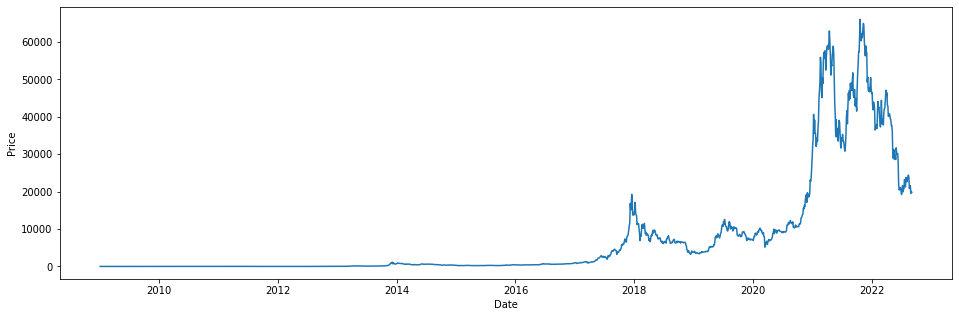

In [47]:
plt.figure(figsize=(16,5))
plt.plot(market_price["Timestamp"], market_price["Price"])
plt.gca().set(xlabel="Date", ylabel="Price")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

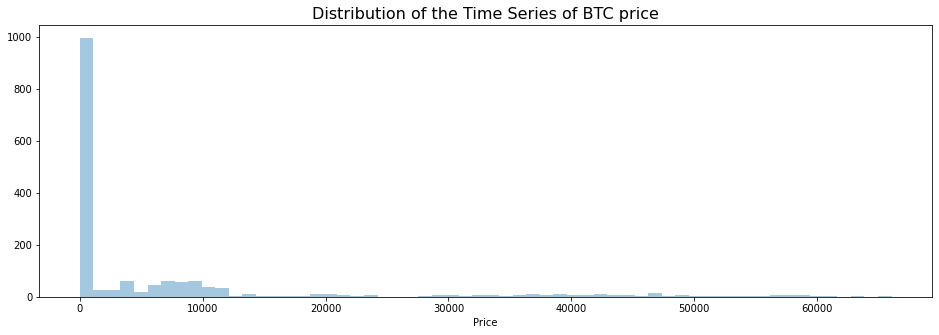

In [64]:
plt.figure(figsize=(16,5))
sns.distplot(market_price["Price"], kde = False, bins = 60)
plt.title('Distribution of the Time Series of BTC price', fontsize=16)
plt.show()

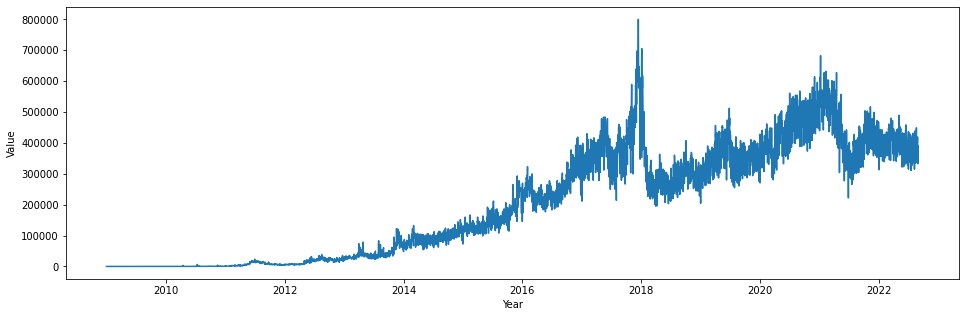

In [48]:
plt.figure(figsize=(16,5))
plt.plot(new_addresses["Timestamp"], new_addresses["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

#new_addresses["New Addresses/v"].plot()

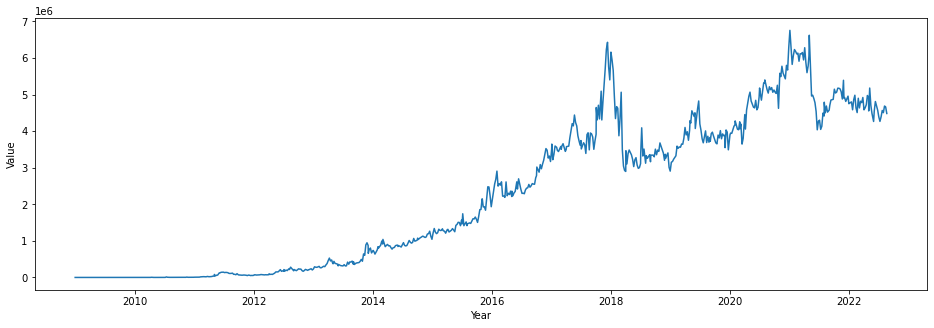

In [49]:
plt.figure(figsize=(16,5))
plt.plot(active_addresses["Timestamp"], active_addresses["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

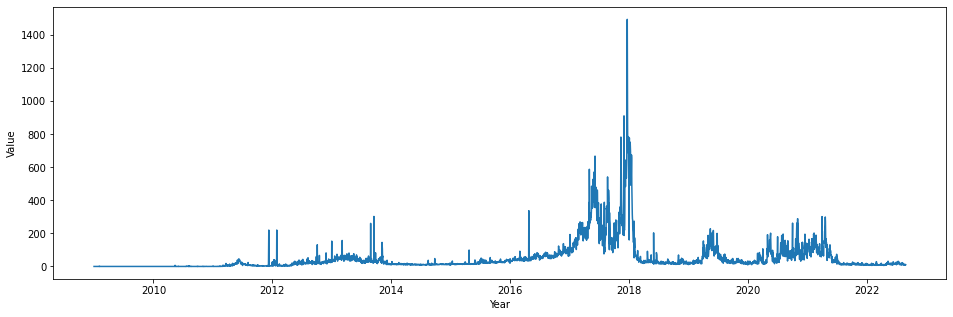

In [50]:
plt.figure(figsize=(16,5))
plt.plot(fees["Timestamp"], fees["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

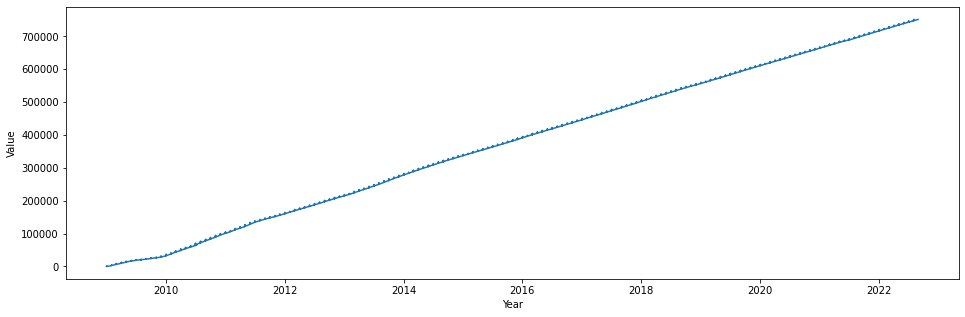

In [51]:
plt.figure(figsize=(16,5))
plt.plot(block_height["Timestamp"], block_height["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

#FIX THIS VIS LIKE GLASSNODE

#CAPIRE PERCHE' SI VEDONO QUEI "PICCHI" (credo si vedano perchè il range y è troppo alto)

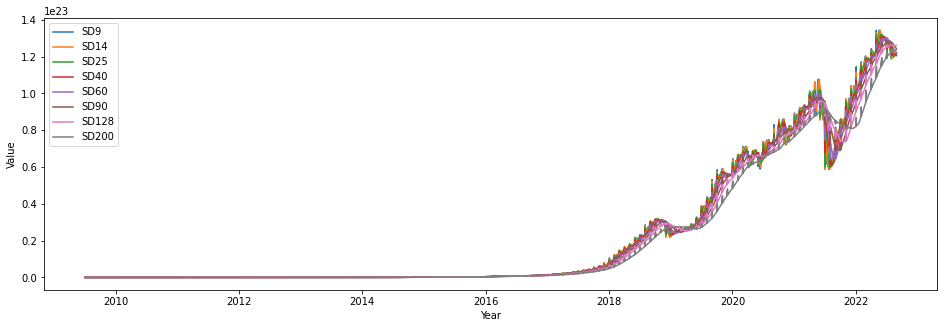

In [52]:
plt.figure(figsize=(16,5))
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma9"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma14"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma25"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma40"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma60"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma90"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma128"])
plt.plot(difficulty_ribbon["Timestamp"], difficulty_ribbon["Difficulty Ribbon/o/ma200"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.legend(['SD9', 'SD14', 'SD25', 'SD40', 'SD60', 'SD90', 'SD128', 'SD200'])
plt.show()


#ADD LEGEND

#ANCHE QUI, CAPIRE PERCHE' SI VEDANO QUEI "PICCHI" (credo si vedano perchè il range y è troppo alto)

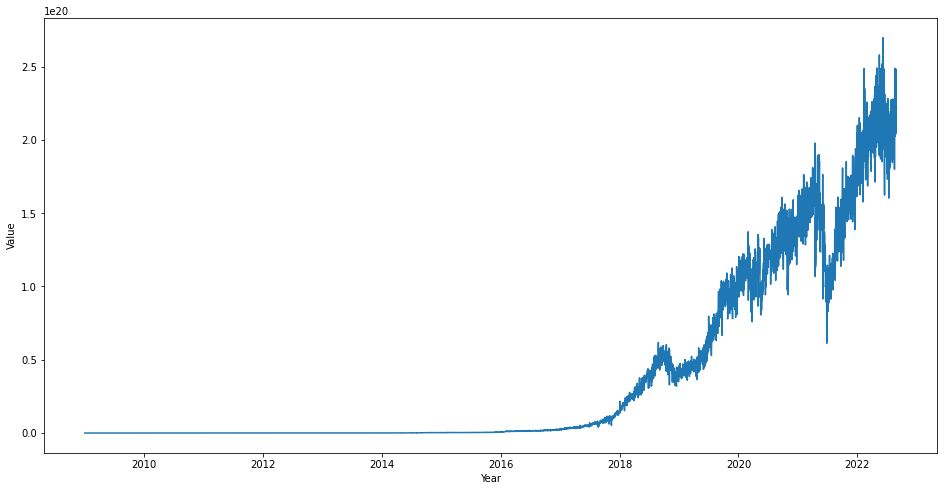

In [53]:
plt.figure(figsize=(16,8))
plt.plot(hash_rate["Timestamp"], hash_rate["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

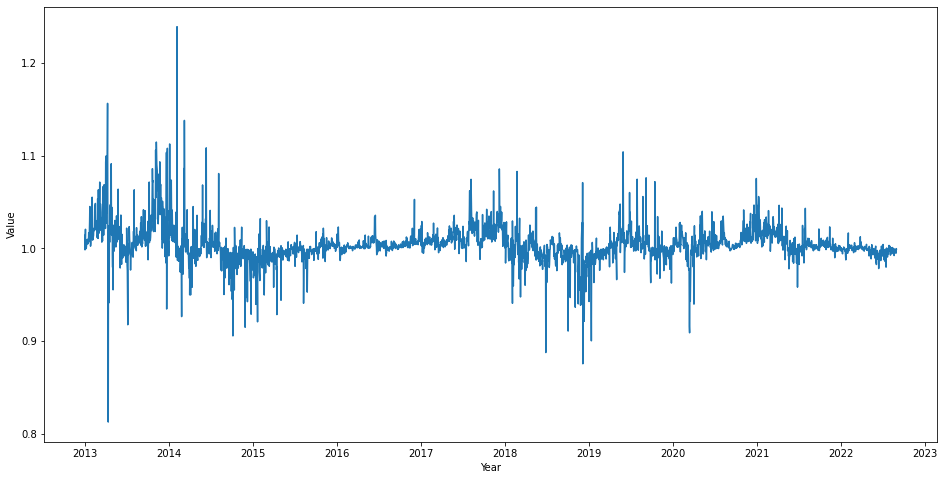

In [54]:
plt.figure(figsize=(16,8))
plt.plot(SOPR["Timestamp"], SOPR["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

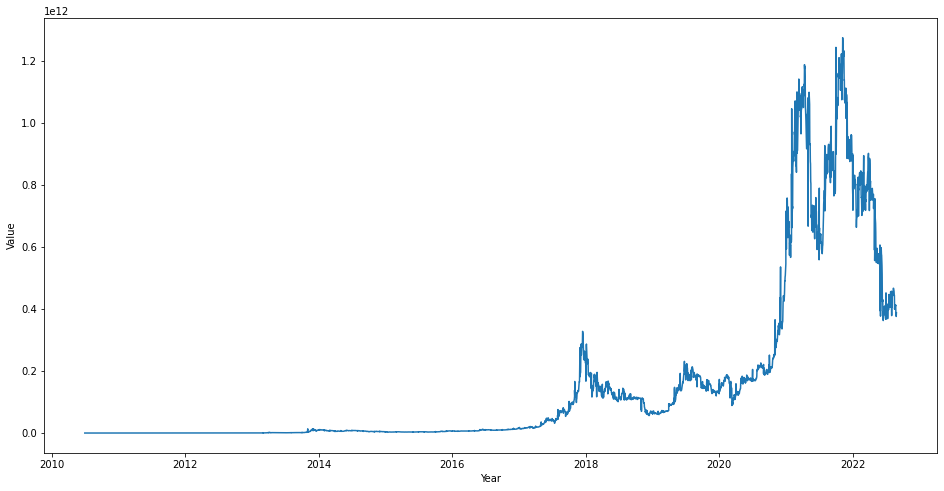

In [55]:
plt.figure(figsize=(16,8))
plt.plot(market_cap_usd["Timestamp"], market_cap_usd["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

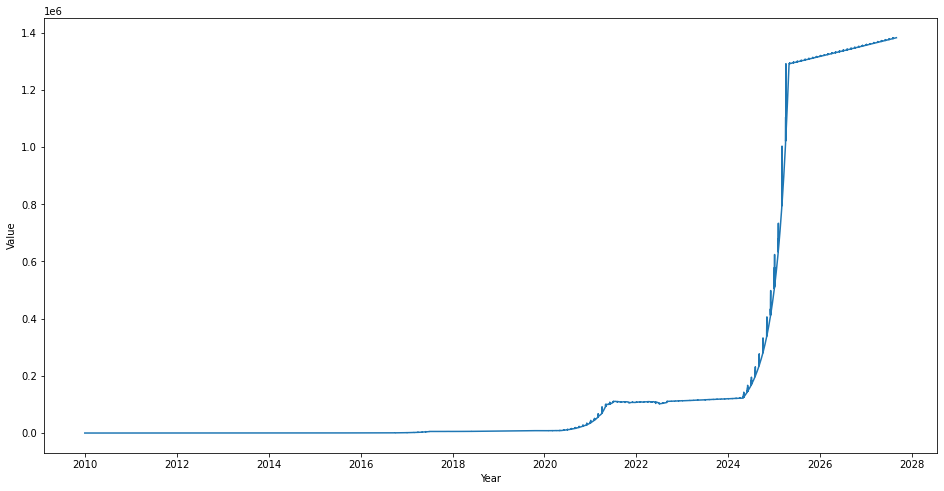

In [56]:
plt.figure(figsize=(16,8))
plt.plot(stock_to_flow["Timestamp"], stock_to_flow["Stock-to-Flow Ratio/o/ratio"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

#E ANCHE QUI, CAPIRE QUEI "PICCHI" PERCHE' SPUNTANO (credo si vedano perchè il range y è troppo alto)